Optimality with Dynamic Motion Primitives in Obstacle Scenarios
====

In [ ]:
# libraries for loading the recorded trajectory and plotting

import matplotlib.pyplot as plt
from utils import get_trajectory

# the trajectory has been recorded in the ROS turtlesim by using the keyboard teleop interface and converted to a csv
# file from a rosbag file.

x, y = get_trajectory("../csv/data.csv")

# Scaling is done so that the node indices in grid search remain integral for reso=1.0
x = [10 * i for i in x]
y = [10 * j for j in y]

plt.plot(x, y)
plt.show()

Path Imitation using DMP
----

In [ ]:
from dmp_discrete import DMPs_discrete
import numpy as np

# specify the number of basis functions in n_bfs, time resolution as dt and total run time.
dmp = DMPs_discrete(n_dmps=2, n_bfs=100, dt=0.01, run_time=1.0)

# learn the weights for the basis functions
dmp.imitate_path(y_des=np.array([x, y]))
print("weights generated for the DMP")

Specify the start and goal positions for the rollout. In this example, we try to just use the same start and goal positions as in the demonstration.

In [ ]:
dmp.y0[0] = x[0]
dmp.y0[1] = y[0]

dmp.goal[0] = x[-1]
dmp.goal[1] = y[-1]

y_track_nc, dy_track_nc, ddy_track_nc, s = dmp.rollout()

For plotting the rolled out trajectory, execute the cell below.

In [ ]:
plt.plot(y_track_nc[:, 0], y_track_nc[:, 1])
plt.scatter(y_track_nc[:, 0], y_track_nc[:, 1])
plt.plot(x, y, color='r')

DMPs with Variable Start and Goal
---

In [ ]:
dmp.y0[0] = 100.0
dmp.y0[1] = 100.0

dmp.goal[0] = 50.0
dmp.goal[1] = 200.0

y_track2, dy_track2, ddy_track2, s2 = dmp.rollout()

plt.plot(y_track2[:, 0], y_track2[:, 1])
plt.scatter(y_track2[:, 0], y_track2[:, 1])
plt.plot(x, y, color='r')

Obstacle Worlds
---

In [ ]:
import math
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry import Point, mapping
from math import sqrt, ceil, floor

# specify the end points of the polygon.
coords = [(30.0, 75), (30, 85), (35, 85), (35, 75)]

obstacle = Polygon(coords)
ob_x, ob_y = obstacle.exterior.xy
plt.plot(y_track_nc[:, 0], y_track_nc[:, 1])
plt.scatter(y_track_nc[:, 0], y_track_nc[:, 1])
plt.plot(x, y, color='r')
plt.plot(ob_x, ob_y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)


As you can see, since the demonstration was for an obstacle free scenario, the path rolled out by the DMP is not able to adapt to the obstacle that is present in the environment. Therefore, for making this adapt to the obstacle scenario, we try out various approaches: (1). Potential fields (2). Grid Search (3). Probabilistic Roadmaps (4). Time-Space Probabilistic Roadmap

Potential Field Methods
---

We first try out a potential field method. A point repulsive field is applied throughout the rolled out trajectory. The point repulsive field for a given point on the DMP, is the closest point on the obstacle to the DMP.

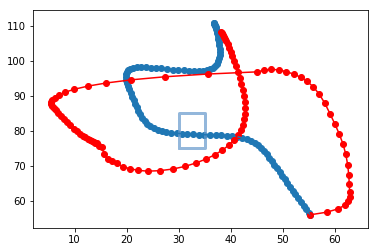

In [18]:
from utils import avoid_obstacles

# TODO: Alternative potential field expressions

dmp.y0[0] = x[0]
dmp.y0[1] = y[0]

dmp.goal[0] = x[-1]
dmp.goal[1] = y[-1]


y_track_pot, dy_track_pot, ddy_track_pot, s = dmp.rollout(obstacles=[obstacle], external_force=avoid_obstacles)


plt.plot(ob_x, ob_y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

plt.plot(y_track_nc[:, 0], y_track_nc[:, 1])
plt.scatter(y_track_nc[:, 0], y_track_nc[:, 1])

plt.plot(y_track_pot[:, 0], y_track_pot[:, 1], color='r')
plt.scatter(y_track_pot[:, 0], y_track_pot[:, 1], color='r')

Grid Search Based Methods
---

Above we can see that the obstacle field is not able to make the path feasible. The approach requires tuning hyperparamters such as the strength of the field. For many scenarios the approach might work but it provides no gurantee of feasibility and optimality. However, it is computationally cheaper than some of the other approaches that would be discussed later.

Now, we try out a Grid based Method, which gives a gurantee of finding a feasible solution if one exists given a small enough grid resolution. The edge weight is defined as the 2D euclidean distance of the grid point from the nearest point on the DMP, which serves as a guiding path. 

Once a graph is constructed from the grid points, a graph search algorithm is used to return the lowest cost path.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

from grid_search import Node, calc_final_path, verify_node, calc_index
from math import modf, sqrt, ceil, floor

# TODO: Animation plot in the single graph

show_animation = False
def calc_obstacle_map(obstacles, reso):

    minx = 0
    miny = 0
    maxx = 1000
    maxy = 1000

    xwidth = round(maxx - minx)
    ywidth = round(maxy - miny)

    # obstacle map generation
    obmap = [[False for i in range(xwidth)] for i in range(ywidth)]
    for ix in range(xwidth):
        x = ix + minx
        for iy in range(ywidth):
            y = iy + miny
            point = Point((reso * x, reso * y))
            for obstacle in obstacles:
                if obstacle.contains(point):
                    obmap[ix][iy] = True
                    break

    return obmap, minx, miny, maxx, maxy, xwidth, ywidth

                    
def dijkstra_planning(sx, sy, gx, gy, obstacles, reso, dmp=None,
                      dmp_vel=None, dt=0.01, deviation_penalty=True):
    """
    :param sx: start x coordinate
    :param sy: start y coordinate
    :param gx: goal x coordinate
    :param gy: goal y coordinate
    :param obstacles: list of shapely polygons
    :param reso: resolution of smaller grids
    :param cost_type: type of cost defining edge weights
    :param dmp: path given by a dmp
    :param dmp_vel: dmp_velocities
    :param dt: time resolution of the dmp
    :return: time parameterised path

    """
    print("start is: ", (sx, sy))
    print("goal is: ", (gx, gy))
    # scale the dmp and its velocities according to the resolution of the grid.
    print("shape of dmp is: ", dmp.shape)
    print("shape of dmp velocity is: ", dmp_vel.shape)
    for i in range(0, len(dmp)):
        for j in range(0, len(dmp[i])):
            dmp[i][j] = dmp[i][j] / reso
            dmp_vel[i][j] = dmp[i][j] / reso

    nstart = Node(round(sx / reso), round(sy / reso), 0.0, -1)

    ngoal = Node(round(gx / reso), round(gy / reso), 0.0, -1, len(dmp))

    ngoal = Node(round(gx / reso), round(gy / reso), 0.0, -1)

    obmap, minx, miny, maxx, maxy, xw, yw = calc_obstacle_map(obstacles, reso)

    motion = [[1, 0, 1],
              [0, 1, 1],
              [-1, 0, 1],
              [0, -1, 1],
              [-1, -1, math.sqrt(2)],
              [-1, 1, math.sqrt(2)],
              [1, -1, math.sqrt(2)],
              [1, 1, math.sqrt(2)]]

    openset, closedset = dict(), dict()
    openset[calc_index(nstart, xw, minx, miny)] = nstart

    while 1:
        c_id = min(openset, key=lambda o: openset[o].cost)
        current = openset[c_id]
        # show graph
        plt.plot(current.x * reso, current.y * reso, "xc")
        if show_animation:            
            if len(closedset.keys()) % 10 == 0:
                plt.pause(0.1)

        if current.x == ngoal.x and current.y == ngoal.y:
            print("[INFO]: searched reached the goal")
            ngoal.pind = current.pind
            ngoal.cost = current.cost
            break

        # Remove the item from the open set
        del openset[c_id]
        # Add it to the closed set
        closedset[c_id] = current

        # expand search grid based on motion model
        for i, _ in enumerate(motion):
            dmp_cost = calculate_dmp_cost(current.x, current.y,
                                          motion[i][0], motion[i][1],
                                          dmp, dmp_vel, obstacles, reso, dt,
                                          dev_penalty=deviation_penalty)
            node = Node(current.x + motion[i][0], current.y + motion[i][1],
                            current.cost + dmp_cost,
                            c_id)

            n_id = calc_index(node, xw, minx, miny)

            if not verify_node(node, obmap, minx, miny, maxx, maxy):
                continue

            if n_id in closedset:
                continue
                
            # Otherwise if it is already in the open set
            if n_id in openset:
                # print("nid exists in openset")
                if openset[n_id].cost > node.cost:
                    openset[n_id].cost = node.cost
                    openset[n_id].pind = c_id

            else:
                openset[n_id] = node
    
    # call to final_path to give out the trail for the lowest cost path.
    rx, ry = calc_final_path(ngoal, closedset, reso)

    return rx, ry


def calculate_dmp_cost(x, y, motion_x, motion_y, dmp, dmp_vel, obstacles=None, reso=1.0, dt=0.01,
                      dev_penalty=True):
    """
    :param x: x coordinate of the point which we are moving to
    :param y: y coordinate of the point which we are moving to
    :param motion_x: distance to be moved along x
    :param motion_y: distance to be moved along y
    :param dmp: reference dmp
    :param dmp_vel: reference dmp velocities
    :param obstacles: list of shapely polygons
    :param reso: resolution of the 2D grid
    :return: cost of the given node

    """

    d = []

    for pt in dmp:
        distance = sqrt((x - pt[0]) ** 2 + (y - pt[1]) ** 2)
        d.append(distance)

    d = np.array(d)

    # closest point on the motion primitive.
    time_index = np.argmin(d)

    # time taken to traverse the required distance, if we were to travel at the velocity at the nearest DMP point.
    delta_t_index = (sqrt(motion_x ** 2 + motion_y ** 2)/sqrt(dmp_vel[time_index][0] ** 2 +
                                                              dmp_vel[time_index][1] ** 2))/dt
    
    if floor(time_index + delta_t_index) < len(dmp):
        
        # get the coordinates on the DMP for t + delta_t 
        dmp_0 = dmp[floor(time_index + delta_t_index)]

        if ceil(time_index + delta_t_index) < len(dmp):
            dmp_1 = dmp[ceil(time_index + delta_t_index)]
            dmp_next = dmp_0 + (dmp_1 - dmp_0) * modf(delta_t_index)[0]

        else:
            dmp_next = dmp_0

    dmp_x = dmp_next[0]
    dmp_y = dmp_next[1]

    obstacle_cost = 0
    if obstacles is not None:
        for obstacle in obstacles:
            pol_ext = LinearRing(obstacle.exterior.coords)
            d = pol_ext.project(Point(reso * (x + motion_x), reso * (y + motion_y)))
            p = pol_ext.interpolate(d)
            obst_potential_pt = list(p.coords)[0]
            dist = sqrt((y + motion_y - round(obst_potential_pt[1]/reso)) ** 2 +
                        (x + motion_x - round(obst_potential_pt[0]/reso)) ** 2)
            obstacle_cost += 1/((dist + 0.0000001) ** 2)

    # print("obstacle cost is: ", obstacle_cost)
    
    cost = sqrt((y + motion_y - dmp_y) ** 2 + (x + motion_x - dmp_x) ** 2) + obstacle_cost 
    
    if dev_penalty:
        cost -= sqrt((y - dmp[time_index][1]) ** 2 + (x - dmp[time_index][0]) ** 2)

    return cost

start is:  (55, 55)
goal is:  (36, 110)
shape of dmp is:  (100, 2)
shape of dmp velocity is:  (100, 2)
[INFO]: searched reached the goal
calculate final path called
final path calculated..


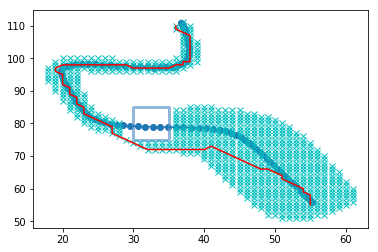

In [23]:
grid_size = 1.0

plt.plot(ob_x, ob_y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

plt.plot(y_track_nc[:, 0], y_track_nc[:, 1])
plt.scatter(y_track_nc[:, 0], y_track_nc[:, 1])

rx, ry = dijkstra_planning(floor(x[0]), floor(y[0]), floor(x[-1]), floor(y[-1]), [obstacle], grid_size,
                          dmp=y_track_nc, dmp_vel=dy_track_nc, dt=dmp.dt)

plt.plot(rx, ry, "-r")

Without deviation penalty for the same goal and environment

start is:  (55, 55)
goal is:  (36, 110)
shape of dmp is:  (100, 2)
shape of dmp velocity is:  (100, 2)
[INFO]: searched reached the goal
calculate final path called
final path calculated..


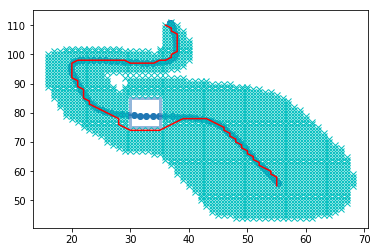

In [25]:
plt.plot(ob_x, ob_y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

plt.plot(y_track_nc[:, 0], y_track_nc[:, 1])
plt.scatter(y_track_nc[:, 0], y_track_nc[:, 1])

rx, ry = dijkstra_planning(floor(x[0]), floor(y[0]), floor(x[-1]), floor(y[-1]), [obstacle], grid_size,
                          dmp=y_track_nc, dmp_vel=dy_track_nc, dt=dmp.dt, deviation_penalty=False)

plt.plot(rx, ry, "-r")